In [ ]:
# Based on the TensFlow course : https://www.tensorflow.org/tutorials/keras/text_classification
# Modified by Mehdi Ammi, Univ. Paris 8

# TensorFlow: Text classification 

In this notebook, you'll learn how to perform text classification starting from plain text files stored on disk. Specifically, you'll train a binary classifier to analyze sentiment using an IMDB dataset. By the end of the notebook, there's an exercise for you to try, where you'll train a multi-class classifier to predict tags for programming questions on Stack Overflow.



In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

## Sentiment Analysis
In this notebook, we'll train a sentiment analysis model to classify movie reviews as either positive or negative, based on the text of the review. This is an example of binary classification, a crucial type of machine learning problem.

The dataset used here is the Large Movie Review Dataset, which includes 50,000 movie reviews from the Internet Movie Database. These are split evenly into 25,000 reviews for training and 25,000 reviews for testing.

### Download and Explore the IMDB Dataset
Let's download and extract the dataset, then examine its directory structure.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
>>
Downloading data from https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

In [ ]:
os.listdir(dataset_dir)

In [ ]:
>>
['imdb.vocab', 'README', 'test', 'imdbEr.txt', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

In [ ]:
>>
['unsup',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'neg',
 'urls_unsup.txt',
 'urls_pos.txt',
 'pos']

### Sample a Review
Let's take a look at one of the movie reviews.

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

In [ ]:
>>
Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.

### Load the Dataset
Next, we'll load the data from disk and prepare it for training. We'll use the text_dataset_from_directory utility, which expects a specific directory structure. Before doing that, let's remove unnecessary folders.

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
# Define the batch size for the dataset
batch_size = 32

# Define the seed for reproducibility
seed = 42

# Load the raw training dataset using the text_dataset_from_directory utility
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',  # Path to the directory containing the training data
    batch_size=batch_size,  # Set the batch size
    validation_split=0.2,  # Specify the fraction of data to be used for validation (20%)
    subset='training',  # Indicate that this subset is for training
    seed=seed  # Set the seed for reproducibility of the data split
)

In [ ]:
>>
Found 25000 files belonging to 2 classes.
Using 20000 files for training.

In [ ]:
As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to model.fit. If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.

### Explore the Data

Let's examine a few examples from our dataset.

In [ ]:
# Iterate over one batch of data from the raw training dataset
for text_batch, label_batch in raw_train_ds.take(1):
    # Loop through the first three examples in the batch
    for i in range(3):
        # Print the text of the review
        print("Review", text_batch.numpy()[i])
        # Print the label of the review
        print("Label", label_batch.numpy()[i])

In [ ]:
>>
Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicated situations, and so does the perspective of the viewer.<br /><br />So is 'Homicide' which from the title tries to set the mind of the viewer to the usual crime drama. The principal characters are two cops, one Jewish and one Irish who deal with a racially charged area. The murder of an old Jewish shop owner who proves to be an ancient veteran of the Israeli Independence war triggers the Jewish identity in the mind and heart of the Jewish detective.<br /><br />This is were the flaws of the film are the more obvious. The process of awakening is theatrical and hard to believe, the group of Jewish militants is operatic, and the way the detective eventually walks to the final violent confrontation is pathetic. The end of the film itself is Mamet-like smart, but disappoints from a human emotional perspective.<br /><br />Joe Mantegna and William Macy give strong performances, but the flaws of the story are too evident to be easily compensated."
Label 0
Review b'Great documentary about the lives of NY firefighters during the worst terrorist attack of all time.. That reason alone is why this should be a must see collectors item.. What shocked me was not only the attacks, but the"High Fat Diet" and physical appearance of some of these firefighters. I think a lot of Doctors would agree with me that,in the physical shape they were in, some of these firefighters would NOT of made it to the 79th floor carrying over 60 lbs of gear. Having said that i now have a greater respect for firefighters and i realize becoming a firefighter is a life altering job. The French have a history of making great documentary\'s and that is what this is, a Great Documentary.....'
Label 1

Notice the reviews contain raw text (with punctuation and occasional HTML tags like <br/>). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the class_names property on the dataset.

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

In [ ]:
>>
Label 0 corresponds to neg
Label 1 corresponds to pos

### Create Validation and Test Datasets

Next, let's create a validation dataset and load the test dataset.

In [ ]:
# Create a validation dataset using the remaining 20% of the training data
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# Load the test dataset
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

In [ ]:
>>
Found 25000 files belonging to 2 classeX

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [ ]:
# Custom standardization function to remove HTML tags and punctuation
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [ ]:
max_features = 10000
sequence_length = 250

# Create a TextVectorization layer with custom standardization
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

### Vectorize the Data

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

In [ ]:
>>
Review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main character is Emma Woodhouse, a young lady from an aristocratic family in Regency England. (Not, as some reviewers have assumed, Victorian England- Austen died before Queen Victoria was even born). Emma is, financially, considerably better off than most Austen heroines such as Elizabeth Bennett or Fanny Price, and has no need to find herself a wealthy husband. Instead, her main preoccupation seems to be finding husbands for her friends. She persuades her friend Harriet to turn down a proposal of marriage from a young farmer, Robert Martin, believing that Harriet should be setting her sights on the ambitious clergyman Mr Elton. This scheme goes disastrously wrong, however, as Elton has no interest in Harriet, but has fallen in love with Emma herself. The speed with which Emma rejects his proposal makes one wonder just why she was so keen to match her friend with a man she regards (with good reason) as an unsuitable marriage partner for herself. This being a Jane Austen plot, Emma turns out to be less of a committed spinster than she seems, and she too finds herself falling in love, leading to further complications.<br /><br />Emma always insists that she will not marry without affection, and when she does find a partner, the handsome Mr Knightley, we feel that this will indeed be an affectionate marriage. It does not, however, seem likely to be a very passionate one (unlike, say, that of Elizabeth Bennett and Mr Darcy). Knightley, who is sixteen years older than Emma (she is 21, he 37), and related to her by marriage, is more like a father-figure than a lover. Much more of a father-figure, in fact, than her actual father, a querulous and selfish old hypochondriac who seems more like her grandfather. When Emma is rude to her unbearably garrulous and tedious friend Miss Bates, it is Knightley who chides her for her lack of manners. (His surname is probably meant to indicate his gentlemanly nature- nineteenth-century gentlemen liked to think of themselves as the modern equivalent of mediaeval knights with their elaborate codes of chivalry). Both Gwyneth Paltrow and Jeremy Northam play their parts very well, but this is not really one of the great screen romances.<br /><br />Of the other characters, I liked Juliet Stephenson\'s vulgar Mrs Elton and Toni Collette\'s Harriet. I know that in the novel Harriet was a na\xc3\xafve young teenager, whereas here she is more like the character Collette played in "Muriel\'s Wedding"- a gauche, slightly overweight twentysomething, fretting about her chances of finding a man. Nevertheless, I felt that this characterisation worked well in the context of the film and did not detract from Austen\'s themes.<br /><br />"Emma" is one of Austen\'s more light-hearted works, without the darker overtones of "Mansfield Park" or even "Pride and Prejudice", and this is reflected on screen. We see a world of beauty and grace, full of stately homes and elegant costumes and fine manners. Apart from the ruffianly gypsies, who make a very brief appearance, the only "poor" people we see are Mrs Bates and her daughter, and, as they live in the sort of picturesque rose-strewn thatched cottage which today would change hands for over \xc2\xa3500,000, we can be sure that their poverty is relative, not absolute. In Emma\'s world, poverty is defined as not having your own stately home. This is, of course, not a comprehensive picture of early nineteenth-century life, but nobody has ever claimed Austen as the Regency equivalent of a kitchen-sink realist. Sophisticated romantic comedy, combined with a keen eye for analysing human character, was more in her line.<br /><br />I would not rate this film quite as highly as the 1994 "Sense and Sensibility" or the recent "Pride and Prejudice"- it tends to drag a bit in the middle, although it has a strong beginning and strong ending- but it is, in the main, a highly enjoyable Austen adaptation. 7/10', shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[2528,   13,    4, 2218,    5,   48,  227,   26,  488,   32,    2,
          83,   86, 1007, 6768, 6996,    5,    2,    1,    3,    9,   13,
         986,  581,   20,  681,  708,    1,   84,    5,    2,  598,    8,
           2, 2174, 1033,   32,    2,  333,   86, 1007, 6768, 6996,   60,
         606,   16, 3114,    3, 5437,  104,  149,  589,   71, 3780,   25,
           8,    2, 4959,    2, 6768, 6887, 1587, 1007,    3,    1,   25,
         986, 1118,  297,  243,   91,  443,   20, 6768, 2630,  129, 1429,
           1,    1,    2,   61,   28,    5,    2, 1539,  653, 2630,   21,
           6,   25,   74,  814, 2353,   37,    2, 6996,  139,  148,   26,
         555,   57,  803,  189,   47,   76,   26,   50,    6,  203,    8,
           2,  781,  701,   47,    7,  101,   30,   39, 3697,  115,    3,
           1,    1,    2,  350,    1,  729, 2744,    3,  282, 1116,   43,
           1,    1, 4055,    6,   39,  104,    1,    1,    2,    1,    3,
           1,   92,   47,   23,   30,  143, 6768, 2141,    1,   44,   32,
         709,    1,    2,  275,  106,    7, 2528,    1,    4,  181,  729,
          35,   33,    1,  215,    8,    1, 1777,   21,   14,   46, 1870,
          25, 5293, 7152, 1777, 6768, 1071,  153, 1573, 2375,   13,   53,
        1461, 2528,    7,    1, 5765,  122,  127,   70,   88, 6768, 8660,
         135,   14, 2722, 7422,   41,    1, 1841,    3,   43,   57,  349,
           6,  163,  733,    4, 3109,  672,  291,   39,  275,    1,  180,
           6,   26, 1578, 2978,   15,   39,  335,   55,    1,   39,  469,
        5926,    6,  459,  185,    4,    1,    5, 1357,   35,    4,  181,
        6023,  639, 1558, 3206,   12, 5926,  139,   26]])>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [ ]:
>>
1287 --->  silent
 313 --->  night
Vocabulary size: 10000

### Apply TextVectorization Layer
You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [ ]:
# Apply the TextVectorization layer to the train, validation, and test datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [ ]:
# Define the embedding dimension size
embedding_dim = 16

# Build the model using a Sequential API
model = tf.keras.Sequential([
  # Add an Embedding layer to map input tokens to vectors of size embedding_dim
  layers.Embedding(max_features, embedding_dim),
  
  # Add a Dropout layer to reduce overfitting by randomly setting input units to 0 with a frequency of 20% at each step
  layers.Dropout(0.2),
  
  # Add a GlobalAveragePooling1D layer to reduce the dimensionality of the input
  layers.GlobalAveragePooling1D(),
  
  # Add another Dropout layer to reduce overfitting
  layers.Dropout(0.2),
  
  # Add a Dense layer with a single unit and a sigmoid activation function for binary classification
  layers.Dense(1, activation='sigmoid')
])

# Print the model summary to see the structure and number of parameters
model.summary()


In [ ]:
>>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
=================================================================
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial.
2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

We'll compile the model with a loss function and an optimizer.

In [ ]:
# Compile the model with BinaryCrossentropy loss and Adam optimizer
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

### Train the model

You will train the model by passing the dataset object to the fit method.

In [ ]:
# Set the number of epochs for training
epochs = 10

# Train the model
history = model.fit(
    train_ds,  # The training dataset
    validation_data=val_ds,  # The validation dataset
    epochs=epochs  # Number of epochs to train the model
)

In [ ]:
>>
Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.6660 - binary_accuracy: 0.6908 - val_loss: 0.6178 - val_binary_accuracy: 0.7740
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5513 - binary_accuracy: 0.7987 - val_loss: 0.5003 - val_binary_accuracy: 0.8202
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4468 - binary_accuracy: 0.8446 - val_loss: 0.4213 - val_binary_accuracy: 0.8464
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3800 - binary_accuracy: 0.8655 - val_loss: 0.3746 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3364 - binary_accuracy: 0.8791 - val_loss: 0.3457 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3058 - binary_accuracy: 0.8887 - val_loss: 0.3265 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2832 - binary_accuracy: 0.8954 - val_loss: 0.3130 - val_binary_accuracy: 0.8736
Epoch 8/10
625/625 [==============================] - 7s 12ms/step - loss: 0.2638 - binary_accuracy: 0.9039 - val_loss: 0.3037 - val_binary_accuracy: 0.8752
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2467 - binary_accuracy: 0.9099 - val_loss: 0.2967 - val_binary_accuracy: 0.8758
Epoch 10/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2324 - binary_accuracy: 0.9168 - val_loss: 0.2921 - val_binary_accuracy: 0.8782

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
>>
782/782 [==============================] - 4s 5ms/step - loss: 0.3104 - binary_accuracy: 0.8733
Loss:  0.31035059690475464
Accuracy:  0.8733199834823608

### Plot Accuracy and Loss over time

model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
>>
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

We'll create plots for the training and validation accuracy and loss.

In [ ]:
# Retrieve history of accuracy and loss
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

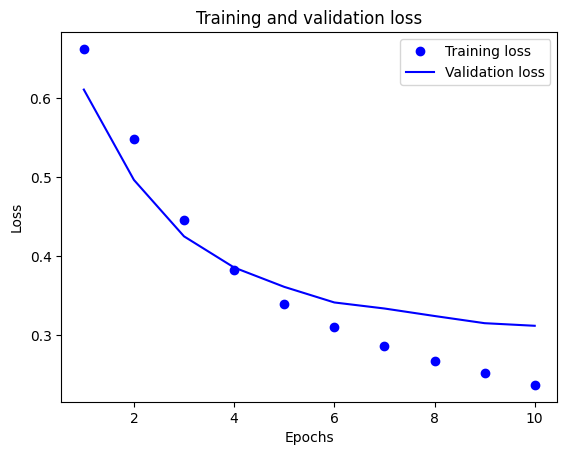

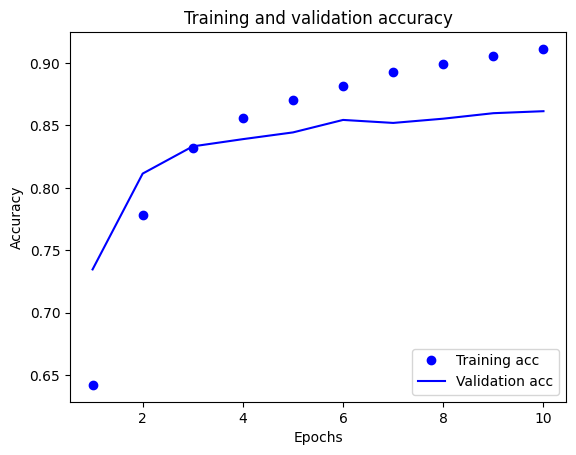

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the tf.keras.callbacks.EarlyStopping callback.

## Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [ ]:
# Create an export model including the TextVectorization layer
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Evaluate the export model on the raw test dataset
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

In [ ]:
>>
782/782 [==============================] - 8s 10ms/step - loss: 0.5889 - accuracy: 0.5000
0.5

### Inference on new data
To get predictions for new examples, you can simply call model.predict().

In [ ]:
# Predict sentiments of new examples
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

In [ ]:
>>
1/1 [==============================] - 1s 526ms/step
array([[0.6534078 ],
       [0.61201787],
       [0.59269434]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for train/test skew.

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

## Exercices

### Exercise 1: Adjust Batch Size

 - Adjust the batch size to 64 and observe how it affects the model's training.
 - Change the batch size to 128 and observe the effects on training and validation accuracy.
 - Experiment with a batch size of 16 and compare the training time with the previous configurations.

### Exercise 2: Increase Embedding Dimension

 - Increase the embedding dimension to 32.
 - Increase the embedding dimension to 64 and observe how it affects the model's performance.
 - Reduce the embedding dimension to 8 and compare the accuracy and loss with the previous configurations.

### Exercise 3: Modify Dropout Rate

 - Modify the dropout rate to 0.3 in the model.
 - Change the dropout rate to 0.5 and observe the effects on the model's performance.
 - Set the dropout rate to 0.1 and compare the validation accuracy with the previous configurations.

### Exercise 4: Add Another Dense Layer

 - Add another Dense layer with 16 units and 'relu' activation before the final Dense layer.
 - Change the number of units in the added Dense layer to 32 and observe the effects on model performance.
 - Replace the 'relu' activation with 'tanh' and compare the training and validation accuracy.

### Exercise 5: Change Optimizer to RMSprop

 - Change the optimizer from 'adam' to 'RMSprop'.
 - Experiment with the 'sgd' optimizer and compare the model's performance with 'adam' and 'RMSprop'.
 - Adjust the learning rate of the 'RMSprop' optimizer to 0.001 and observe the effects on training.

### Exercise 6: Use EarlyStopping Callback

 - Implement EarlyStopping to prevent overfitting.
 - Modify the patience parameter to 5 and observe how it affects the training process.
 - Change the monitor parameter to 'val_accuracy' and compare the results.

### Exercise 7: Implement L2 Regularization

 - Add L2 regularization to the Dense layer.
 - Change the L2 regularization factor to 0.001 and observe the effects on model performance.
 - Add L2 regularization to the additional Dense layer from Exercise 5 and compare the results.

### Exercise 8: Implement Text Augmentation

 - Implement text augmentation to the dataset to improve model generalization.
 - Experiment with different text augmentation techniques such as synonym replacement or random insertion and observe the effects on model performance.
 - Compare the results of training the model with and without text augmentation.

### Exercise 9: Implement Batch Normalization

 - Task: Add batch normalization layers to the model.
 - Remove one of the Batch Normalization layers and observe how it affects the training and validation accuracy.
 - Experiment with placing Batch Normalization layers before the Dropout layers and compare the results.

### Exercise 10 : Implement Bidirectional LSTM

- Replace the GlobalAveragePooling1D layer with a Bidirectional LSTM layer.
- Experiment with different numbers of LSTM units (e.g., 32, 128) and observe the effects on the model's performance.
- Add another Bidirectional LSTM layer and compare the training and validation accuracy.